In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
import pandas as pd
import glob
import os 

# Define the folder containing the .txt files
folder_path = '/mnt/home/tudomlumleart/ceph/03_GaussianChainSimulation/20240627/results_WeightStructureOptim_20240711'

# Initialize a list to store data
data = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        # Parse parameters from filename
        params = filename[:-4].split('_')[4:7]
        
        # Read the content of the file into a DataFrame
        file_path = os.path.join(folder_path, filename)
        file_df = pd.read_csv(file_path, delimiter=',')  # Adjust delimiter as needed
        file_df.columns = ['kl_loss_weights', 'mse_loss_structures']  # Adjust column names as needed
        
        params_name = ['num_templates', 'weight_dist', 'noise_std']
        
        # Repeat parameters for each row in the file_df
        for i, param in enumerate(params):
            file_df[params_name[i]] = float(param)
        
        # Append the DataFrame to the list
        data.append(file_df)

# Concatenate all the individual DataFrames into one
final_df = pd.concat(data, ignore_index=True)


2024-07-18 09:49:26.288488: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# calculate kl loss from two random set of numbers 
num_temp = np.arange(1, 101)
kl_loss_array = []
for iter in tqdm(range(1000)):
    kl_loss_list = []
    for i in num_temp:
        random_number_1 = scipy.special.softmax(np.random.rand(i))
        random_number_2 = scipy.special.softmax(np.random.rand(i))
        kl_loss = np.sum(scipy.special.kl_div(random_number_1, random_number_2))
        kl_loss_list.append(kl_loss)
    kl_loss_array.append(kl_loss_list)

# Generate random polymers with number of templates and calculate frobenius norm
# Try to assign the closest two random polymers to each other
num_temp = [2, 5, 10, 50, 100, 250, 500]
mse_loss_array = []
for iter in tqdm(range(100)):
    mse_loss_list = []
    for i in num_temp:
        rand_polymer_1 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
        rand_polymer_2 = [generate_gaussian_chain(100, 10, 20) for _ in range(i)]
        rand_polymer_1 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_1])
        rand_polymer_2 = np.array([squareform(pdist(x)).flatten() for x in rand_polymer_2])
        assigned_polymer_1, assigned_polymer_2 = assign_clusters(rand_polymer_1, rand_polymer_2)
        mse_loss = np.mean([np.linalg.norm(x-y) for x, y in zip(assigned_polymer_1, assigned_polymer_2)])
        mse_loss_list.append(mse_loss)
    mse_loss_array.append(mse_loss_list)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
mse_loss_pd = {
    'num_templates': np.repeat(num_temp, 100),
    'mse_loss': np.array(mse_loss_array).flatten()
}
mse_loss_mean = np.mean(mse_loss_array, axis=0)

<Axes: xlabel='num_templates', ylabel='mse_loss'>

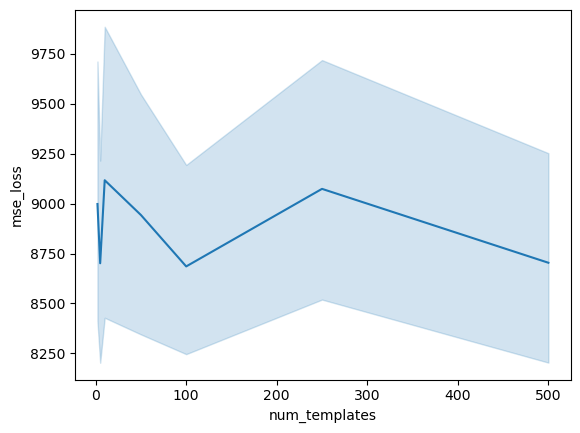

In [8]:
sns.lineplot(data=mse_loss_pd, x='num_templates', y='mse_loss')

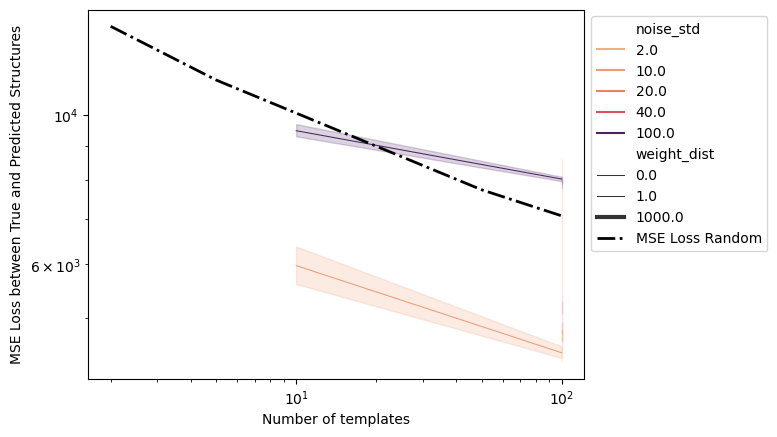

In [14]:
num_temp = [2, 5, 10, 50, 100]
conditions = (final_df['num_templates'] < 250) 
conditional_df = final_df[conditions]
p = sns.lineplot(data=conditional_df, x='num_templates', y='mse_loss_structures', hue='noise_std', size='weight_dist', palette="flare")
plt.plot(num_temp, mse_loss_mean[:len(num_temp)], label='MSE Loss Random', linestyle='-.', linewidth=2, color='black')
plt.xscale('log')
plt.yscale('log')
p.set_ylabel('MSE Loss between True and Predicted Structures')
p.set_xlabel('Number of templates')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.savefig(os.path.join(save_path, 'mse_loss_structure_combined.png'), dpi=300, bbox_inches='tight')